In [ ]:
!pip install shapely geopandas rasterio rtree pygeos

In [420]:
import shapely
import shapely.geometry
import geopandas as gpd
import rasterio
import rasterio.features
import matplotlib.pyplot as plt
import skimage.io
import skimage.filters
import scipy.ndimage
import rasterio.plot
import numpy as np
import math
from itertools import product

## Setup

In [101]:
def plot_in_area(ps, area, zoom_to=None):
  fig = plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1, 1, 1)
  gpd.GeoSeries([area.geometry]).boundary.plot(edgecolor="black", ax=ax)
  gpd.GeoSeries(ps).geometry.boundary.plot(edgecolor="red", ax=ax)
  if zoom_to is not None:
    ax.set_xlim(zoom_to[:2])
    ax.set_ylim(zoom_to[2:])

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
BASE_PATH = "/content/gdrive/MyDrive/Thesis"

In [ ]:
!ln -s $BASE_PATH/other /content/other
!ln -s $BASE_PATH/datasets /content/datasets

In [72]:
polygons = gpd.read_file("/content/other/overlap_correction/polygons_258.geojson")
ho_polygons = gpd.read_file("/content/other/overlap_correction/polygons_ho.geojson")
areas = gpd.read_file("/content/other/overlap_correction/areas.geojson")
tiles = gpd.read_file("/content/other/overlap_correction/tiles.geojson")

## Rasterizing polygons

These are particular polygons we chose for our prototype because they exhibit the property that some part of them is outside the training area.

In [135]:
ep1 = spolygons.loc[68, "geometry"]
ep2 = spolygons.loc[43, "geometry"]

In [183]:
ezt1 = (-13.679890316967283, -13.679743123565654, 13.484648028182363, 13.484831970496398)

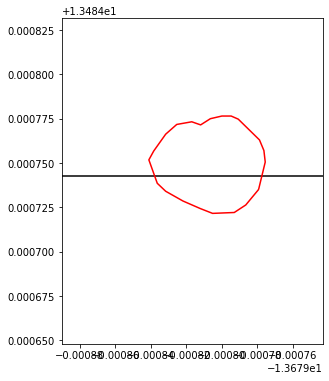

In [501]:
plot_in_area([ep1], area=area, zoom_to=ezt1)

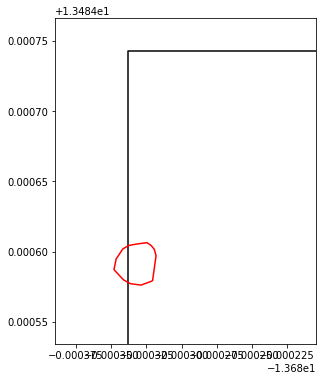

In [414]:
plot_in_area([ep2], area,
             zoom_to=(-13.680389942942474, -13.680204147772159, 13.484534379499031, 13.484766561058711))

Below, we focus on the first polygon.

We can rasterize the polygon within its bounding box (which facilitates computing the different types of centroids [standard or energy] and also certain filters) or within the training area.

We can translate between the bounding box raster and the frame raster using their respective transforms and copy the relevant pixels. So we think its better to rasterize within the bounding box and then translate when needed.

This approach should also speed-up the generation of GTs because we can cache the rasters of each polygon inside its bounding box as well as the relevant transforms.

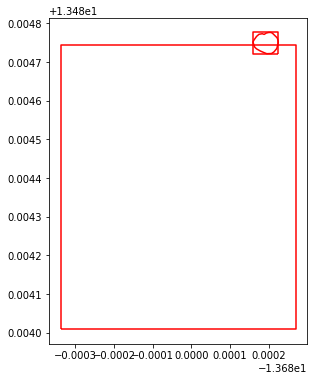

In [412]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
box1 = shapely.geometry.box(*ep1.bounds)
gpd.GeoSeries([box1, ep1, area.geometry]).boundary.plot(edgecolor="red", ax=ax)
ax.set_ylim(ezt1[])

In [523]:
def plot_raster(raster, transform, vectors=None, cmap="viridis",
                figsize=(6, 6), zoom_to=None):
  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(1, 1, 1)
  extent = rasterio.plot.plotting_extent(raster, transform=transform)
  ax.imshow(raster, cmap=cmap, extent=extent)
  if vectors is not None:
    gpd.GeoSeries(vectors).boundary.plot(edgecolor="red", ax=ax)
  if zoom_to is not None:
    ax.set_xlim(zoom_to[:2])
    ax.set_ylim(zoom_to[2:])
  return None

In [509]:
def rasterize_polygon(polygon, area, tile, target="bbox", all_touched=True, dtype="float32"):
  with rasterio.open(f"/content/datasets/sahara-sahel/StackedImages/{tile['file_path']}", "r") as src:
    if target == "bbox":
      box = shapely.geometry.box(*polygon.bounds)
      window = rasterio.features.geometry_window(src, [box])
    else:
      window = rasterio.features.geometry_window(src, [area.geometry])
    out_shape=(window.height, window.width)
    transform = src.window_transform(window)
    raster = rasterio.features.geometry_mask([polygon],
                                          transform=transform,
                                          out_shape=out_shape,
                                          invert=True, all_touched=all_touched)
    raster = raster.astype(dtype)

  return raster, transform

Below, we see that is preferable to use `all_touched=True` when rasterizing.

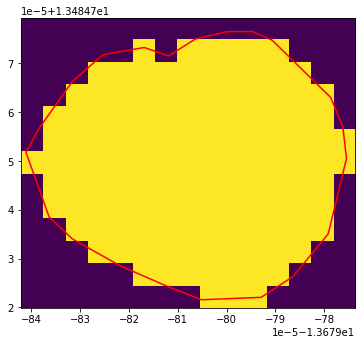

In [518]:
m0, t0 = rasterize_polygon(ep1, area, tile, all_touched=False)
plot_raster(m0, t0, [ep1])

In [ ]:
m1, t1 = rasterize_polygon(ep1, area, tile, all_touched=True)
plot_raster(m1, t1, [ep1])

This is our final goal: to display the relevant pixels of the rasterized polygon within its training area.

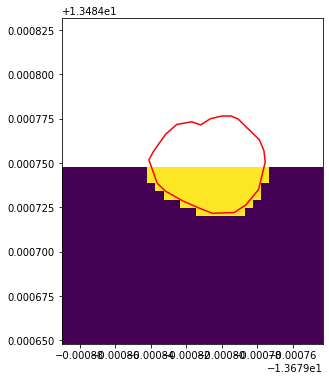

In [527]:
m2, t2 = rasterize_polygon(ep1, area, tile, all_touched=True,
                           target="frame")
plot_raster(m2, t2, [ep1], zoom_to=ezt1)

We start prototyping how to copy pixels from the compact bounding-box raster array into a (probably wery sparse) array with the same dimensions as the frame raster.

In [428]:
# Here we see which values from m1 would be copied
# into an array with the same dimensions as m2
def what_is_copied(m1, t1, m2, t2, cmap="viridis"):
  m1c = np.zeros_like(m1)
  for src in np.argwhere(m1):
    src = tuple(src)
    dst = ((src[1], src[0]) * t1) * ~t2
    if 0 <= dst[0] < m2.shape[0] and 0 <= dst[1] < m2.shape[1]:
      m1c[src] = m1[src]
  fig = plt.figure(figsize=(12, 6))
  extent = rasterio.plot.plotting_extent(m1, transform=t1)
  ax = fig.add_subplot(1, 2, 1)
  ax.imshow(m1, cmap=cmap, extent=extent)
  gpd.GeoSeries([ep1]).boundary.plot(edgecolor="red", ax=ax)
  ax = fig.add_subplot(1, 2, 2)
  ax.imshow(m1c, cmap=cmap, extent=extent)
  gpd.GeoSeries([ep1]).boundary.plot(edgecolor="red", ax=ax)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  import sys


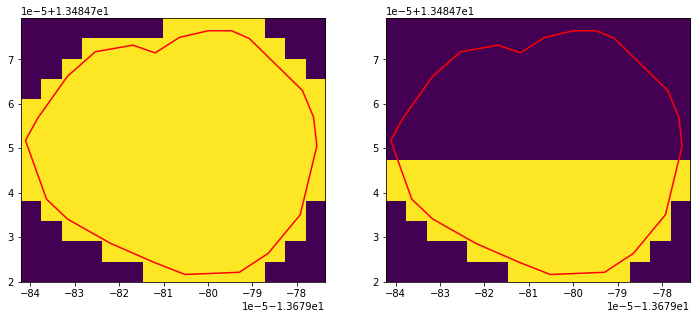

In [429]:
what_is_copied(m1, t1, m2, t2)

As expected, the centroid wouldn't be copied:

In [430]:
def standard_centroid(mask):
    xs = np.argwhere(mask)
    if len(xs) > 0:
        return np.round(np.sum(xs, axis=0) / len(xs)).astype(int)
    return np.array(list(mask.shape)) // 2

sc = standard_centroid(m1)
scm = np.zeros_like(m1)
scm[tuple(sc)] = 1.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  import sys


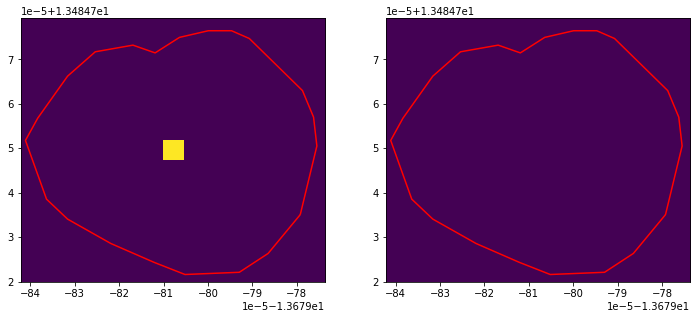

In [431]:
what_is_copied(scm, t1, m2, t2)

However, if we apply a Gaussian filter on the centroid mask, some values are actually copied.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  import sys


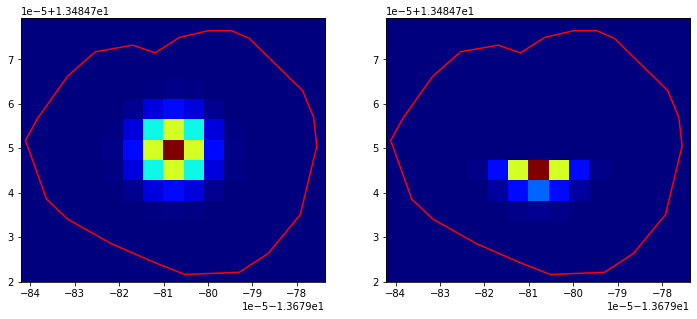

In [432]:
gscm = skimage.filters.gaussian(scm, 1.0, mode="nearest")
what_is_copied(gscm, t1, m2, t2, cmap="jet")

If we use a bigger value for sigma its more noticeable:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  import sys


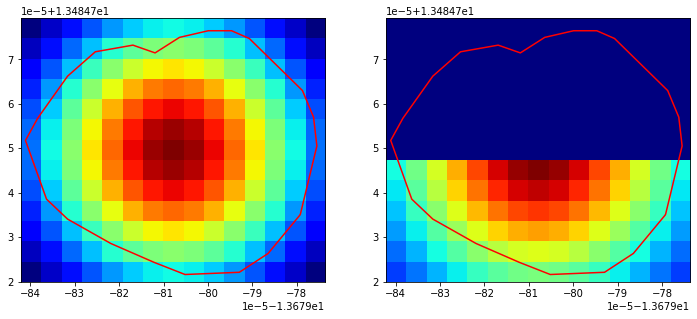

In [433]:
gscm = skimage.filters.gaussian(scm, 5.0, mode="nearest")
what_is_copied(gscm, t1, m2, t2, cmap="jet")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  import sys


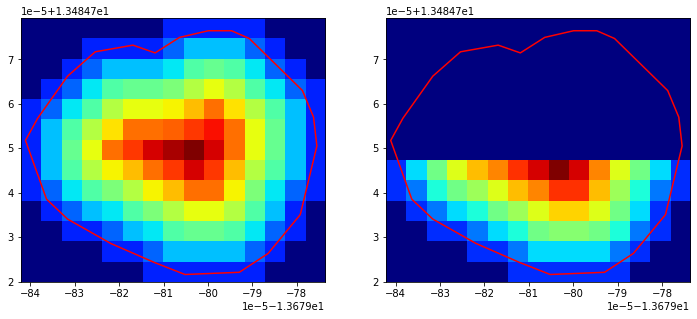

In [434]:
edt = scipy.ndimage.distance_transform_edt(np.pad(m1, (20,)))[20:-20, 20:-20]
what_is_copied(edt, t1, m2, t2, cmap="jet")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  import sys


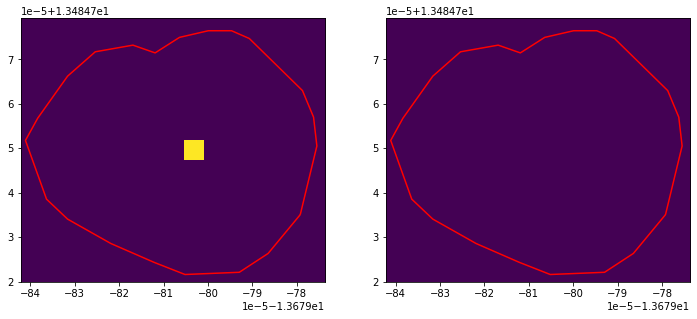

In [436]:
def energy_centroid(mask):
    xs = np.argwhere(np.logical_not(mask < np.max(mask)))
    if len(xs) > 0:
        return np.round(np.sum(xs, axis=0) / len(xs)).astype(int)
    return np.array(list(mask.shape)) // 2

ec = energy_centroid(edt)
ecm = np.zeros_like(m1)
ecm[tuple(ec)] = 1.0

what_is_copied(ecm, t1, m2, t2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  import sys


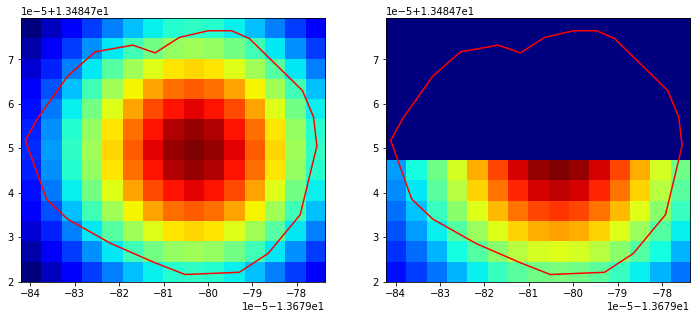

In [437]:
gecm = skimage.filters.gaussian(ecm, 5.0, mode="nearest")
what_is_copied(gecm, t1, m2, t2, cmap="jet")

In [480]:
def what_is_copied(m1, t1, m2, t2, cmap="viridis"):
  m1c = np.zeros_like(m1)
  for src in np.argwhere(m1):
    src = tuple(src)
    dst = ((src[1], src[0]) * t1) * ~t2
    if 0 <= dst[0] < m2.shape[0] and 0 <= dst[1] < m2.shape[1]:
      m1c[src] = m1[src]
  fig = plt.figure(figsize=(12, 6))
  extent = rasterio.plot.plotting_extent(m1, transform=t1)
  ax = fig.add_subplot(1, 2, 1)
  ax.imshow(m1, cmap=cmap, extent=extent)
  gpd.GeoSeries([ep1]).boundary.plot(edgecolor="red", ax=ax)
  ax = fig.add_subplot(1, 2, 2)
  ax.imshow(m1c, cmap=cmap, extent=extent)
  gpd.GeoSeries([ep1]).boundary.plot(edgecolor="red", ax=ax)

def perform_add(src, src_t, dst, dst_t):
  for i in range(src.shape[0]):
    for j in range(src.shape[1]):
      (b, a) = ((j, i) * src_t) * ~dst_t
      if 0 <= a < dst.shape[0] and 0 <= b < dst.shape[1]:
        a = math.ceil(a)
        b = math.ceil(b)
        dst[a, b] += src[i, j]
  return dst

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Right multiplication will be prohibited in version 3.0


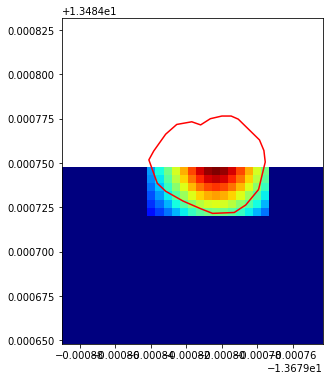

In [529]:
m3 = np.zeros_like(m2)
m3 = perform_add(gecm, t1, m3, t2)
plot_raster(m3, t2, [ep1], zoom_to=ezt1, cmap="jet")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Right multiplication will be prohibited in version 3.0


(13.484648028182363, 13.484831970496398)

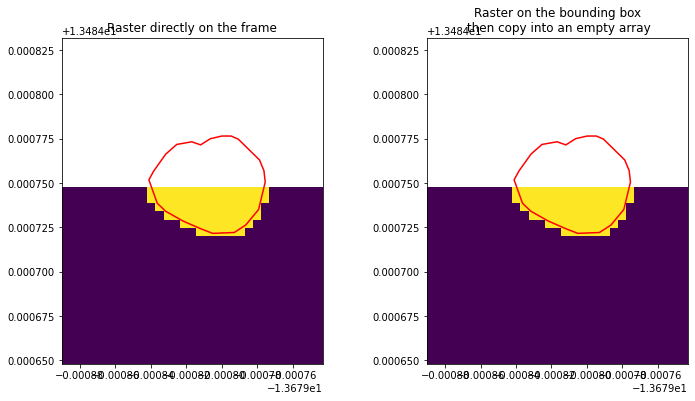

In [531]:
# We compare with the Rasterio polygon raster on the frame.
m3 = np.zeros_like(m2)
m3 = perform_add(m1, t1, m3, t2)

extent = rasterio.plot.plotting_extent(m2, transform=t2)
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.set_title("Raster directly on the frame")
ax1.imshow(m2, cmap="viridis", extent=extent)
gpd.GeoSeries([ep1]).boundary.plot(edgecolor="red", ax=ax1)
ax2.set_title("Raster on the bounding box\n then copy into an empty array")
ax2.imshow(m3, cmap="viridis", extent=extent)
gpd.GeoSeries([ep1]).boundary.plot(edgecolor="red", ax=ax2)
ax1.set_xlim(ezt1[:2])
ax1.set_ylim(ezt1[2:])
ax2.set_xlim(ezt1[:2])
ax2.set_ylim(ezt1[2:])

## Fixing polygon annotations

### Overlapped polygons

In [45]:
initial_scale = 0.90
spolygons = polygons.copy()
spolygons["geometry"] = spolygons.geometry.scale(xfact=initial_scale, yfact=initial_scale, origin="center")

In [97]:
area, tile = areas.iloc[1], tiles.iloc[2]

In [79]:
p1 = spolygons.loc[12, "geometry"]
p2 = spolygons.loc[13, "geometry"]
p3 = spolygons.loc[14, "geometry"]

In [47]:
p1.overlaps(p2), p1.overlaps(p3), p2.overlaps(p3)

(False, True, True)

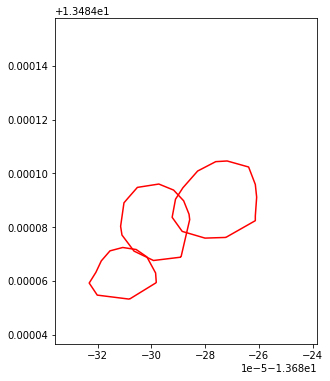

In [102]:
plot_in_area([p1, p2, p3], area,
             zoom_to=(-13.680335790678159, -13.680238266536094, 13.484036596109716, 13.484157936374217))

In [53]:
i13 = p1.intersection(p3)
i23 = p2.intersection(p3)

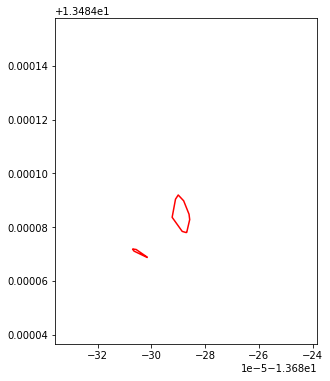

In [54]:
plot_in_area([i13, i23], area,
             zoom_to=(-13.680335790678159, -13.680238266536094, 13.484036596109716, 13.484157936374217))

In [55]:
p1c = p1.difference(i13)
p2c = p2.difference(i23)

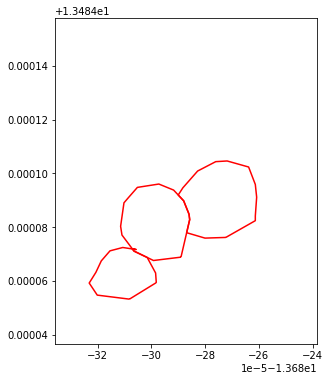

In [57]:
plot_in_area([p1c, p2c, p3], area,
             zoom_to=(-13.680335790678159, -13.680238266536094, 13.484036596109716, 13.484157936374217))

In [58]:
p1c2 = p1.difference(p3)
p2c2 = p2.difference(p3)

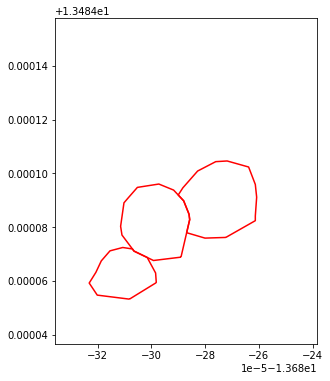

In [59]:
plot_in_area([p1c2, p2c2, p3], area,
             zoom_to=(-13.680335790678159, -13.680238266536094, 13.484036596109716, 13.484157936374217))

In [60]:
p1c2.overlaps(p3), p2c2.overlaps(p3)

(True, True)

### Heavily overlapped polygons
Warning: Found heavily overlapped polygons in area_id=82, id_left=73261, id_right=73263

Warning: Found heavily overlapped polygons in area_id=287, id_left=35889, id_right=61798

Warning: Found heavily overlapped polygons in area_id=462, id_left=51013, id_right=51744

In [105]:
ho_area1, ho_tile1 = areas.iloc[0], tiles.iloc[3]
ho_area2, ho_tile2 = areas.iloc[2], tiles.iloc[1]
ho_area3, ho_tile3 = areas.iloc[3], tiles.iloc[0]

In [83]:
initial_scale = 0.90
ho_spolygons = ho_polygons.copy()
ho_spolygons["geometry"] = ho_spolygons.geometry.scale(xfact=initial_scale, yfact=initial_scale, origin="center")

In [111]:
ho_pair1 = [ho_spolygons.loc[0, "geometry"], ho_spolygons.loc[1, "geometry"]]
ho_pair2 = [ho_spolygons.loc[2, "geometry"], ho_spolygons.loc[3, "geometry"]]
ho_pair3 = [ho_spolygons.loc[4, "geometry"], ho_spolygons.loc[5, "geometry"]]

In [114]:
zt1 = (-11.404242868550488, -11.40419292237942, 14.670183432224594, 14.670220039344521)
zt2 = (-14.138004858201832, -14.137874918564021, 14.568924719804983, 14.569063466191281)
zt3 = (-12.275695488626585, -12.275650193835736, 23.379954764538297, 23.37998783609838)

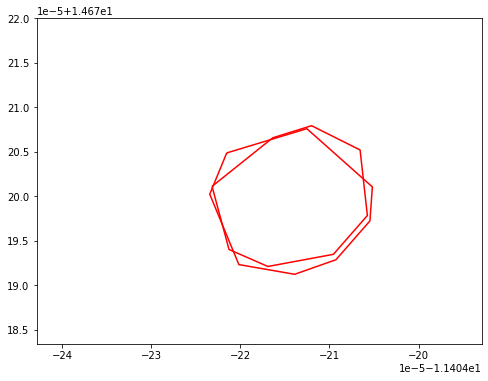

In [112]:
plot_in_area(ho_pair1, ho_area1, zoom_to=zt1)

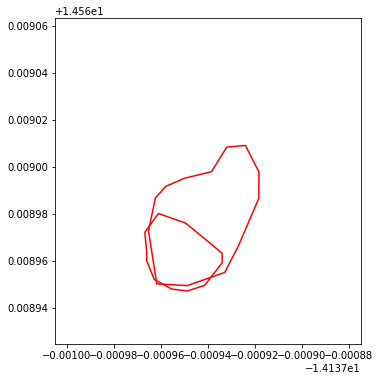

In [113]:
plot_in_area(ho_pair2, ho_area2, zoom_to=zt2)

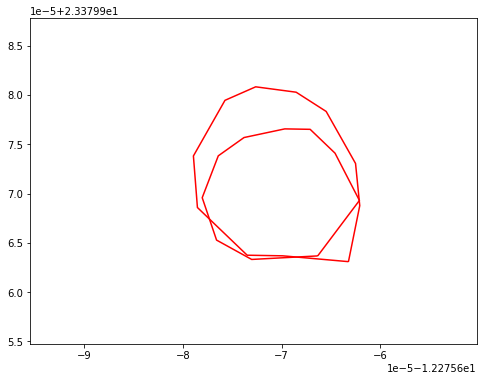

In [115]:
plot_in_area(ho_pair3, ho_area3, zoom_to=zt3)

In [119]:
ho_pair3[0].covers(ho_pair3[1])

False